In [1]:
# Setup to equivalently run in colab or run locally
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    %cd /content
    # Colab-specific widget support
    from google.colab import output
    output.enable_custom_widget_manager()
    !pip install ipympl --quiet
    !pip install sigpy --quiet
    %matplotlib widget

    # Clone repo and cd into it to behave like running locally
    if not os.path.exists("arc_zte"):
      print("Cloning repo")
      !git clone https://github.com/mikgroup/arc_zte.git
    %cd /content/arc_zte
else:
    # Local Jupyter 
    %matplotlib notebook

In [8]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import sigpy.plot as pl
import os
import glob
from tqdm import tqdm

from zte_recon.data_zte import Data_Arc_ZTE
from zte_recon.traj_zte import Traj_ArcZTE_from_kacq, Traj_RadialZTE_from_kacq, Traj_CalcPhyllo_ZTE
from zte_recon.recon_gridding import recon_adjoint_postcomp_coilbycoil
from zte_recon.arc_zte_traj import read_params_from_kacq
from zte_recon.plot import plot_coherence_pathways_from_coords
from zte_recon.util.os_util import set_gpu

from arc_zte_sim.metrics import cov_uniformity_metric, percentage_TRs_with_refocusing_metric
from arc_zte_sim.theta_i_schemes import FurthestDist_CostFunction

In [3]:
# Reconstruction parameters
FOV_scale = 1
FOV_scale_dir = [1,1,1]
img_shape = [256,256,256]
rBW = 31.25e3

# To account for coil ringing, drop extra points at spoke start
ndrop_ROpts = 1 

# Device for recon. -1 for CPU, else >= 0
set_gpu(1)

In [12]:
# Set local data path (download from link on README)
data_path = './data/ge_phantom/'

# Figure 3

## Load phantom data

In [15]:
# Golden angle rotations of Arc-ZTE segments
seg_rot_file = './rot_txt_files/seg_golden3d_rotMats.txt'

################

### Furthest theta_i's scheme - purely maximize coverage
h5_save_dir = local_data_path + 'furthest_angle53/'
kacq_file = glob.glob(h5_save_dir + 'kacq_arc_zte*')[-1]
acq_params = read_params_from_kacq(kacq_file)

Furthest_thetas_data = Data_Arc_ZTE(kacq_file, seg_rot_file, acq_params, h5_save_dir,
                                    FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, 
                                    ndrop_ROpts=ndrop_ROpts)
Furthest_thetas_data.gradient_corr(-0.25)

################

### Random theta_i's scheme - choose randomly
h5_save_dir = local_data_path + 'random_angle53/'
kacq_file = glob.glob(h5_save_dir + 'kacq_arc_zte*')[-1]
acq_params = read_params_from_kacq(kacq_file)

Random_thetas_data = Data_Arc_ZTE(kacq_file, seg_rot_file, acq_params, h5_save_dir,
                                    FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, 
                                    ndrop_ROpts=ndrop_ROpts)
Random_thetas_data.gradient_corr(-0.25)

################

### Optimization-based scheme to choose theta_i's
h5_save_dir = local_data_path + 'optim_angle53/'
kacq_file = glob.glob(h5_save_dir + 'kacq_arc_zte*')[-1]
acq_params = read_params_from_kacq(kacq_file)

Optim_thetas_data = Data_Arc_ZTE(kacq_file, seg_rot_file, acq_params, h5_save_dir,
                                    FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, 
                                    ndrop_ROpts=ndrop_ROpts)
Optim_thetas_data.gradient_corr(-0.25)

Loading ksp from h5 dir: /mikLKS/shreya/data_for_arczte_paper/ge_phantom/furthest_angle53/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.25
Loading ksp from h5 dir: /mikLKS/shreya/data_for_arczte_paper/ge_phantom/random_angle53/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.25
Loading ksp from h5 dir: /mikLKS/shreya/data_for_arczte_paper/ge_phantom/optim_angle53/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.25


## Coverage uniformity metrics

In [16]:
nSpk = Optim_thetas_data.spokes_per_seg

print(f"Furthest thetas: U = {cov_uniformity_metric(Furthest_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000):.2e}")
print(f"Random thetas: U = {cov_uniformity_metric(Random_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000):.2e}")
print(f"Optimized thetas: U = {cov_uniformity_metric(Optim_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000):.2e}")

Furthest thetas: U = 1.14e+00
Random thetas: U = 9.65e-01
Optimized thetas: U = 1.10e+00


## Plot coherence pathways

<IPython.core.display.Javascript object>


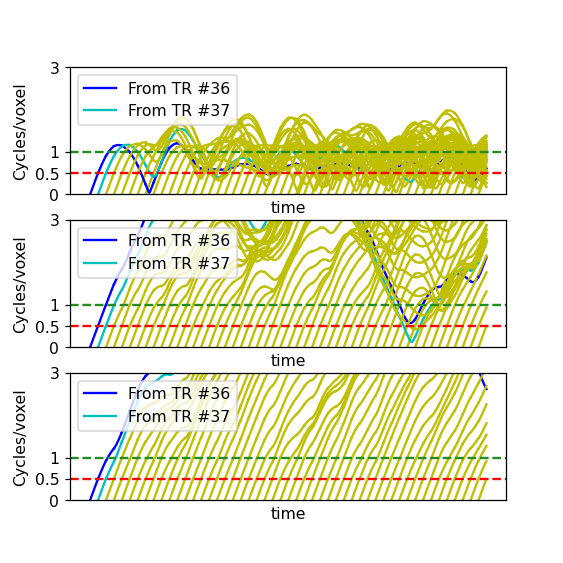

In [10]:
nSpokes_plot = 50
spoke_start_idx = 35

plt.figure(figsize=(5,5))
ax1 = plt.subplot(311)
plot_coherence_pathways_from_coords(Furthest_thetas_data.coord_radial_spokes, nSpokes_plot, spoke_start_idx)

ax2 = plt.subplot(312)
plot_coherence_pathways_from_coords(Random_thetas_data.coord_radial_spokes, nSpokes_plot, spoke_start_idx)

ax3 = plt.subplot(313)
plot_coherence_pathways_from_coords(Optim_thetas_data.coord_radial_spokes, nSpokes_plot, spoke_start_idx)

## Gridding reconstruction of fully-sampled acquisitions from each scheme

In [7]:
#### Furthest theta scheme ####

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Furthest_thetas_data.combine_waspiHires_flat()
# Gridding reconstruction
coil_ims_furthest_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                        coord=coord_hires_waspi, 
                                                        img_shape=img_shape, 
                                                        oversamp=2, norm="ortho")
# coil combination
im_furthest_thetas_grid = sp.rss(coil_ims_furthest_thetas, axes=0) 

#### Random theta scheme ####

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Random_thetas_data.combine_waspiHires_flat()
# Gridding reconstruction
coil_ims_random_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                        coord=coord_hires_waspi, 
                                                        img_shape=img_shape, 
                                                        oversamp=2, norm="ortho")
# coil combination
im_random_thetas_grid = sp.rss(coil_ims_random_thetas, axes=0)

#### Optimized theta scheme ####

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Optim_thetas_data.combine_waspiHires_flat()
# Gridding reconstruction
coil_ims_optim_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                        coord=coord_hires_waspi, 
                                                        img_shape=img_shape, 
                                                        oversamp=2, norm="ortho")
# coil combination
im_optim_thetas_grid = sp.rss(coil_ims_optim_thetas, axes=0)

Coil-by-coil Gridding recon: 100%|██████████████| 12/12 [01:01<00:00,  5.11s/it]


Coil-by-coil recon finished


Coil-by-coil Gridding recon: 100%|██████████████| 12/12 [01:02<00:00,  5.19s/it]


Coil-by-coil recon finished


Coil-by-coil Gridding recon: 100%|██████████████| 12/12 [01:01<00:00,  5.09s/it]


Coil-by-coil recon finished


<IPython.core.display.Javascript object>


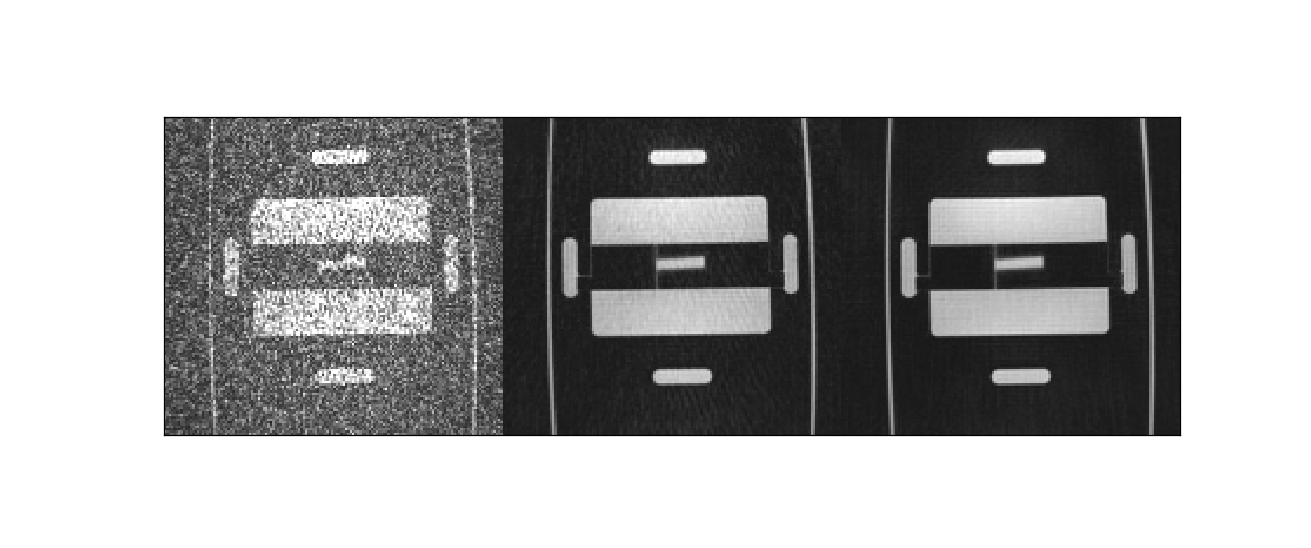

In [11]:
slice_num = 110
im_plot = np.stack((
                im_furthest_thetas_grid[56:200, slice_num, 75:210],
                im_random_thetas_grid[56:200, slice_num, 75:210], 
                im_optim_thetas_grid[56:200, slice_num, 75:210]), axis=0
           )
pl.ImagePlot(im_plot)

# Figure 4

## Load ZTE trajectories

In [13]:
opxres = 256
spokes_per_seg = 384
num_segs = 172
num_segs_lowres = 4

In [14]:
# Path that points to data dir with kacq files from scan
data_h5_dir = './example_traj_kacq_files/'

# golden angle rotations of Arc-ZTE segments
seg_rot_file = 'rot_txt_files/seg_golden3d_rotMats.txt' 


### ArcZTE 13 deg - calculates traj from grad kacq saved by sequence code
kacq_file = glob.glob(data_h5_dir + 'kacq_arc_zte13deg*')[-1]
arcZTE_13deg = Traj_ArcZTE_from_kacq(opxres, seg_rot_file, kacq_file)

### ArcZTE 53 deg - calculates traj from grad kacq saved by sequence code
kacq_file = glob.glob(data_h5_dir + 'kacq_arc_zte53deg*')[-1]
arcZTE_53deg = Traj_ArcZTE_from_kacq(opxres, seg_rot_file, kacq_file)

### ArcZTE 83 deg - calculates traj from grad kacq saved by sequence code
kacq_file = glob.glob(data_h5_dir + 'kacq_arc_zte83deg*')[-1]
arcZTE_83deg = Traj_ArcZTE_from_kacq(opxres, seg_rot_file, kacq_file)


### Standard ZTE - calculates traj from endpoints kacq saved by sequence code
endpoints_txt_path = glob.glob(data_h5_dir + 'kacq_stdzte*')[-1]
stdZTE = Traj_RadialZTE_from_kacq(opxres, endpoints_txt_path, 
                                  spokes_per_seg, num_segs_lowres)

### Phyllotaxis ZTE - calculates trajectory from formula
smoothness = 10
gm_flag = False
segsPerInterleaf = 1
phylloZTE = Traj_CalcPhyllo_ZTE(opxres, smoothness, 
                                gm_flag, segsPerInterleaf, 
                                spokes_per_seg, num_segs, 
                                num_segs_lowres)

### AZTEK - calculates traj from endpoints kacq saved by sequence code
endpoints_txt_path = glob.glob(data_h5_dir + 'kacq_aztek*')[-1]
aztekZTE = Traj_RadialZTE_from_kacq(opxres, endpoints_txt_path, 
                                    spokes_per_seg, num_segs_lowres)

# Compile into list
scheme_list = [arcZTE_13deg, arcZTE_53deg, arcZTE_83deg, 
               aztekZTE, phylloZTE, stdZTE]

## Calculate coverage uniformity vs. number of spokes

In [9]:
### Calculate coverage uniformity # spokes < 1 segment
nSpokes_test = np.concatenate(np.arange(50, 360, 50), 
                              np.array([spokes_per_seg]))
cov_metrics = np.zeros((len(scheme_list), len(nSpokes_test)))
seed = 0

print(f"Calculating coverage uniformity for endpoints")
for j, scheme in enumerate(scheme_list): # loop over ZTE schemes
    
    for i, nSpk in enumerate(tqdm(nSpokes_test)): # loop over diff spokes
        cov_metrics[j, i] = cov_uniformity_metric(
                                    scheme.coord_sampl_hires[0:nSpk, -1, :], 
                                    n=10000, seed=seed)        

### Calculate coverage uniformity over # spokes > 1 segment
nSpokes_test2 = np.concatenate((np.array([200]), np.arange(400, 9000, 400)))
cov_metrics2 = np.zeros((len(scheme_list), len(nSpokes_test2)))

print(f"Calculating coverage uniformity for endpoints")
for j, scheme in enumerate(scheme_list): # loop over ZTE schemes
    
    for i, nSpk in enumerate(tqdm(nSpokes_test2)): # loop over diff spokes
        cov_metrics2[j, i] = cov_uniformity_metric(
                                scheme.coord_sampl_hires[0:nSpk, -1, :], 
                                n=10000, seed=seed)

Calculating coverage uniformity for endpoints


100%|██████████████████████████████████████████████| 8/8 [01:13<00:00,  9.22s/it]


Calculating coverage uniformity for endpoints


100%|█████████████████████████████████████████| 23/23 [1:15:49<00:00, 197.82s/it]


<IPython.core.display.Javascript object>


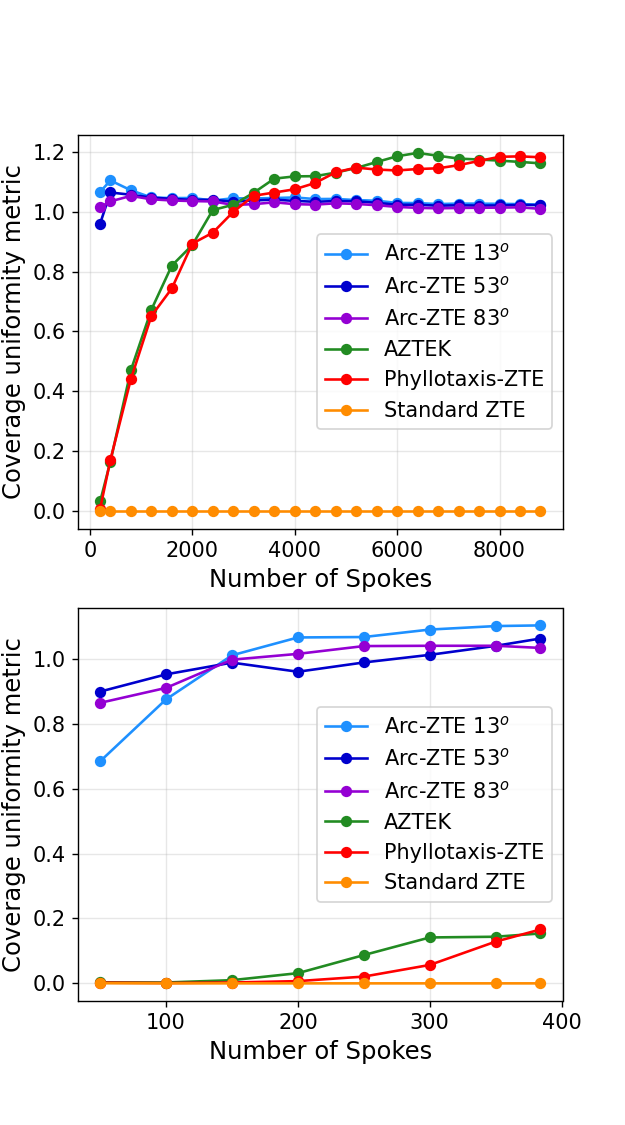

In [11]:
# Plot coverage uniformity over number of spokes for < 1 segment
plt.figure(figsize=(5,9))

#######################

ax = plt.subplot(212)
colors = ['dodgerblue', 'mediumblue',  'darkviolet']
list_angles = [13, 53, 83]

for i in range(3):
    plt.plot(nSpokes_test, cov_metrics[i, :], '.-', markersize=11, 
             label='Arc-ZTE '+ str(list_angles[i]) + '$^o$', c=colors[i])

ax.tick_params(axis='x', labelsize=12) 
ax.tick_params(axis='y', labelsize=12) 
plt.plot(nSpokes_test, cov_metrics[3, :], '.-', markersize=11, 
         label='AZTEK', c='forestgreen')
plt.plot(nSpokes_test, cov_metrics[4, :], '.-', markersize=11, 
         label='Phyllotaxis-ZTE', c='red')
plt.plot(nSpokes_test, cov_metrics[5, :], '.-', markersize=11, 
         label='Standard ZTE', c='darkorange')
plt.legend(fontsize=12)

plt.xlabel('Number of Spokes', fontsize=14)
plt.ylabel('Coverage uniformity metric', fontsize=14)
plt.grid(True, alpha=0.3)

####################

ax2 = plt.subplot(211)
colors = ['dodgerblue', 'mediumblue',  'darkviolet']
for i in range(3):
    plt.plot(nSpokes_test2, cov_metrics2[i, :], '.-', markersize=11, 
             label='Arc-ZTE '+ str(list_angles[i]) + '$^o$', c=colors[i])
    
plt.plot(nSpokes_test2, cov_metrics2[3, :], '.-', markersize=11, 
         label='AZTEK', c='forestgreen')
plt.plot(nSpokes_test2, cov_metrics2[4, :], '.-', markersize=11, 
         label='Phyllotaxis-ZTE', c='red')
plt.plot(nSpokes_test2, cov_metrics2[5, :], '.-', markersize=11, 
         label='Standard ZTE', c='darkorange')

ax2.tick_params(axis='x', labelsize=12) 
ax2.tick_params(axis='y', labelsize=12) 

plt.legend(fontsize=12)
plt.xlabel('Number of Spokes', fontsize=14)
plt.ylabel('Coverage uniformity metric', fontsize=14)
plt.grid(True, alpha=0.3)

## Plot coherence pathways

<IPython.core.display.Javascript object>


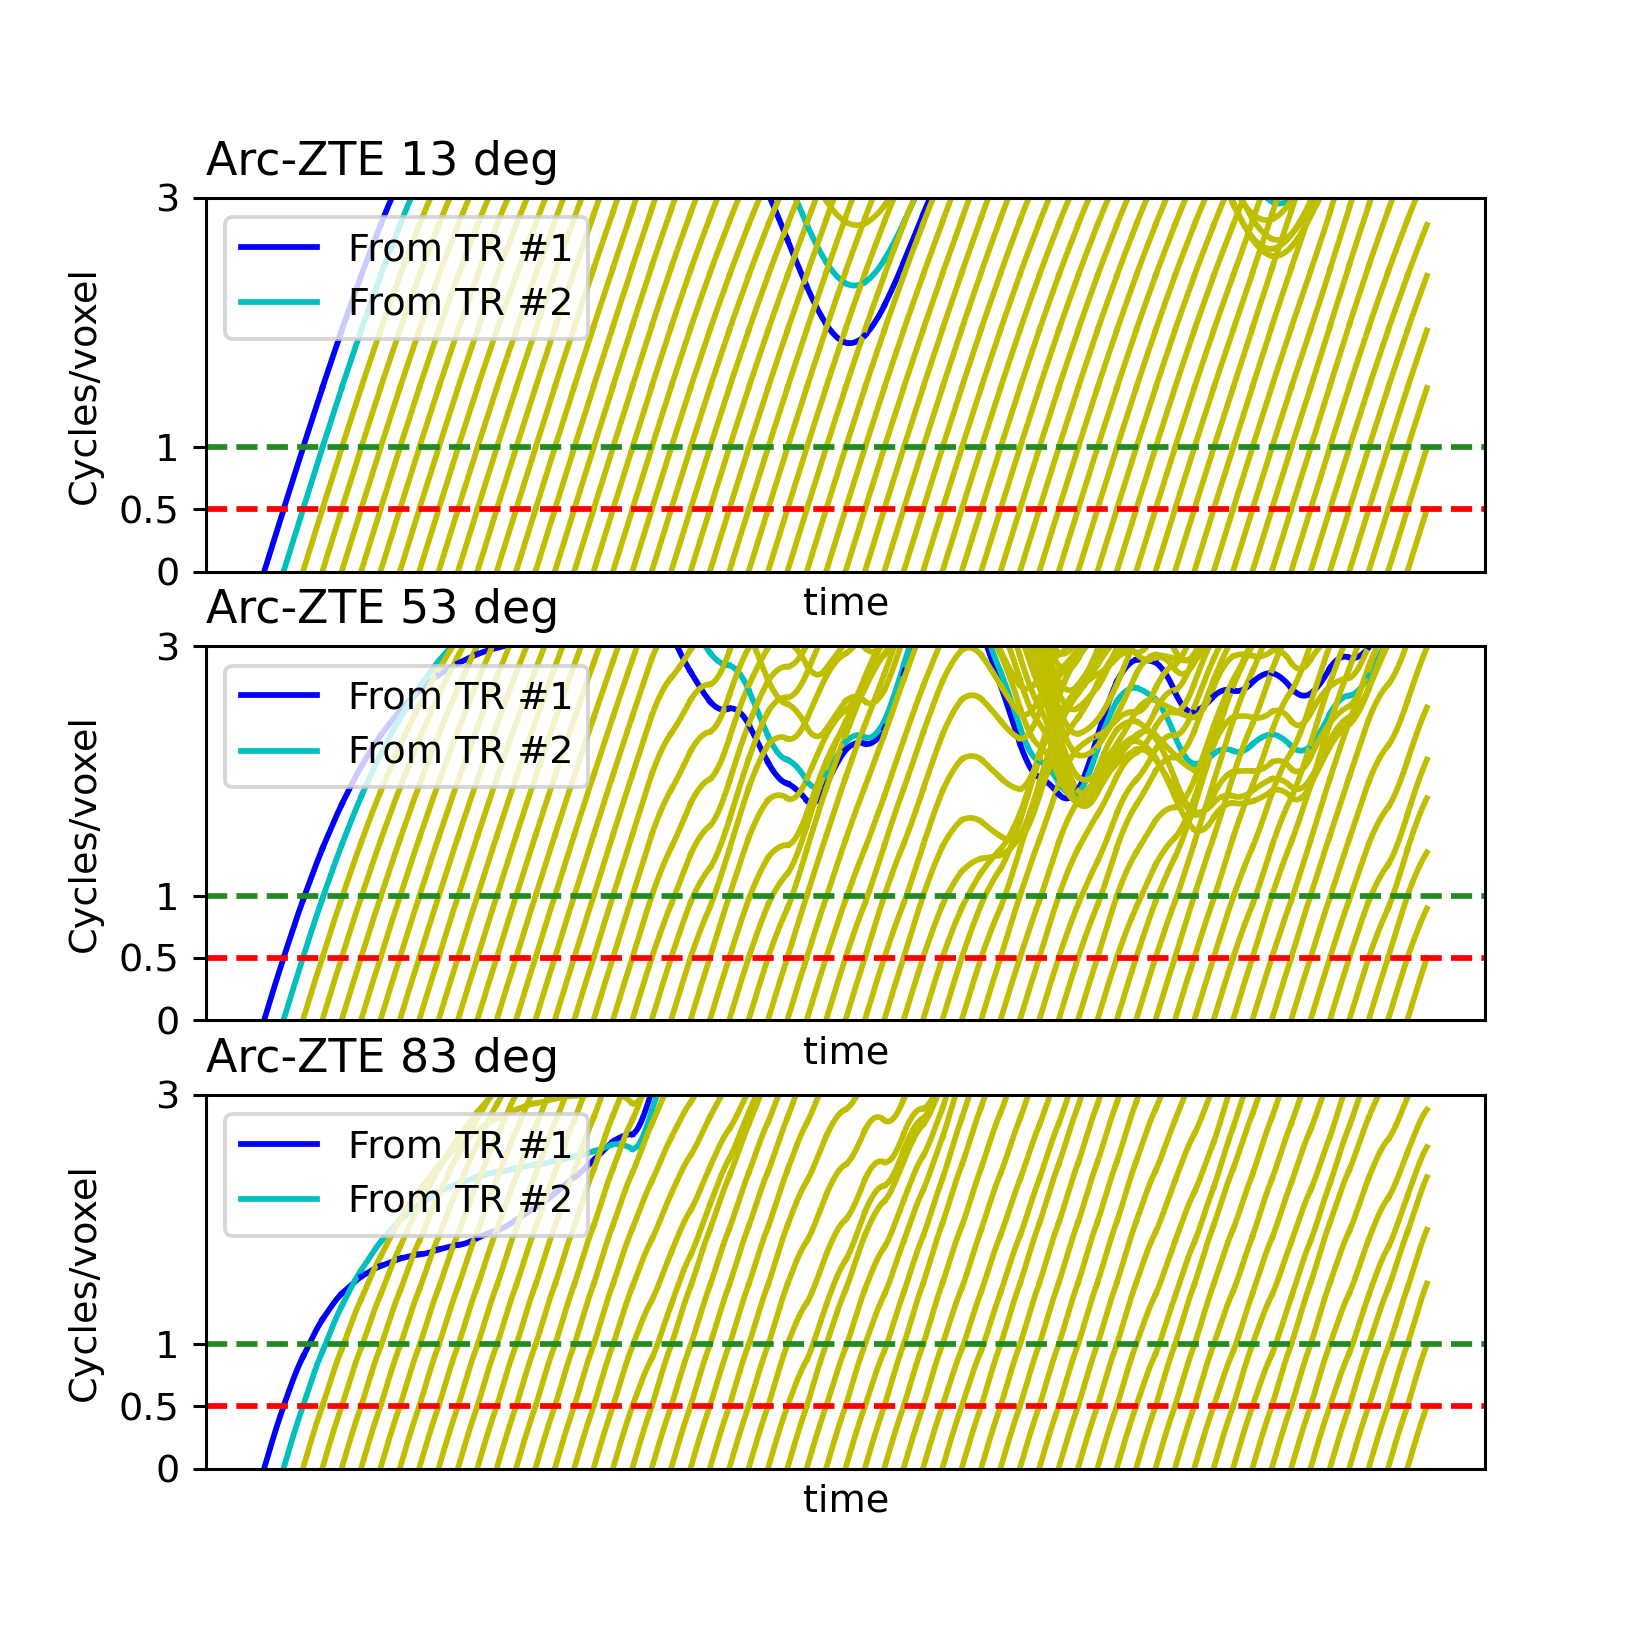

In [95]:
nSpokes_plot = 60
spoke_start_idx = 0

plt.figure(figsize=(6,6))
ax1 = plt.subplot(311)
ax1.set_title(f"Arc-ZTE 13 deg", loc='left')
plot_coherence_pathways_from_coords(scheme_list[0].coord_sampl_hires, 
                                    nSpokes_plot, spoke_start_idx, 
                                    legend_loc='upper right')

ax2 = plt.subplot(312)
ax2.set_title(f"Arc-ZTE 53 deg", loc='left')
plot_coherence_pathways_from_coords(scheme_list[1].coord_sampl_hires, 
                                    nSpokes_plot, spoke_start_idx, 
                                    legend_loc='upper right')

ax3 = plt.subplot(313)
ax3.set_title(f"Arc-ZTE 83 deg", loc='left')
plot_coherence_pathways_from_coords(scheme_list[2].coord_sampl_hires, 
                                    nSpokes_plot, spoke_start_idx, 
                                    legend_loc='upper right')